# CKA

In [3]:
import numpy as np
import torch
import sys
import os
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../')
from sample_batch_data import prepare_data, get_batch

sys.path.append('../../')
from decision_transformer.models.decision_transformer import DecisionTransformer

## Functions for CKA computation

In [4]:
def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.dot(x.T)
  sq_norms = np.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = np.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  if not np.allclose(gram, gram.T):
    raise ValueError('Input must be a symmetric matrix.')
  gram = gram.copy()

  if unbiased:
    # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
    # L. (2014). Partial distance correlation with methods for dissimilarities.
    # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
    # stable than the alternative from Song et al. (2007).
    n = gram.shape[0]
    np.fill_diagonal(gram, 0)
    means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
    means -= np.sum(means) / (2 * (n - 1))
    gram -= means[:, None]
    gram -= means[None, :]
    np.fill_diagonal(gram, 0)
  else:
    means = np.mean(gram, 0, dtype=np.float64)
    means -= np.mean(means) / 2
    gram -= means[:, None]
    gram -= means[None, :]

  return gram


def cka(gram_x, gram_y, debiased=False):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

  normalization_x = np.linalg.norm(gram_x)
  normalization_y = np.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y + 1e-6)


def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
  # This formula can be derived by manipulating the unbiased estimator from
  # Song et al. (2007).
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """
  features_x = features_x - np.mean(features_x, 0, keepdims=True)
  features_y = features_y - np.mean(features_y, 0, keepdims=True)

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))

  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

def compute_cka(activation_1, activation_2, reward_state_action, timestep=-1):

    if reward_state_action == 'reward':
        idx = timestep * 3
    elif reward_state_action == 'state':
        idx = timestep * 2
    elif reward_state_action == 'action':
        idx = timestep * 1
    else:
        print("Specify either 'reward', 'state', or 'action'.")

    # activationの次元（activation_1.shape[1]）とcontextの次元（activation_1.shape[2]）を同一次元に潰す
    if len(activation_1.shape) == 3:
        activation_1 = activation_1[:, :, idx]
    elif len(activation_1.shape) == 4:
        activation_1 = activation_1[:, :, idx, idx]
    if len(activation_2.shape) == 3:
        activation_2 = activation_2[:, :, idx]
    elif len(activation_2.shape) == 4:
        activation_2 = activation_2[:, :, idx, idx]

    cka_from_examples = cka(gram_linear(activation_1.numpy()), gram_linear(activation_2.numpy()), debiased=True)

    return cka_from_examples

def plot_cka(cka_matrix, reward_state_action, model1, model2, env_name, dataset_name, seed, epoch1, epoch2, block):
    
    sns.set_style("ticks")
    sns.set_context("paper", 1.5, {"lines.linewidth": 2})

    ax = sns.heatmap(cka_matrix, vmin=0, vmax=1, square=True)  # , cmap='bone'
    ax.invert_yaxis()
    if model1 == 'dt':
        label1 = 'random init'
    else:
        label1 = model1
    if model2 == 'dt':
        label2 = 'random init'
    else:
        label2 = model2
    if block:
        plt.xlabel(f'{label2.upper()} Block')
        plt.ylabel(f'{label1.upper()} Block')
    else:
        plt.xlabel(f'{label2.upper()} Layers')
        plt.ylabel(f'{label1.upper()} Layers')
    plt.tight_layout()
    if block:
        plt.savefig(f'figs/cka_block_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
    else:
        plt.savefig(f'figs/cka_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.pdf')
    plt.show()

## Function for running CKA computation

In [5]:
def run_cka(
    seed=666,
    model1='gpt2',
    model2='gpt2',
    epoch1=40,
    epoch2=40,
    env_name_list=['hopper', 'halfcheetah', 'walker2d'],
    block=False,
    no_context=False
    ):

    for env_name in env_name_list:
        
        torch.manual_seed(seed)

        dataset_name = 'medium'

        if model1 == 'gpt2':
            pretrained_lm1 = 'gpt2'
        elif model1 == 'clip':
            pretrained_lm1 = 'openai/clip-vit-base-patch32'
        elif model1 == 'igpt':
            pretrained_lm1 = 'openai/imagegpt-small'
        elif model1 == 'dt':
            pretrained_lm1 = False

        variant = {
            'embed_dim': 768,
            'n_layer': 12,
            'n_head': 1,
            'activation_function': 'relu',
            'dropout': 0.2, # 0.1
            'load_checkpoint': False if epoch1==0 else f'../../checkpoints/{model1}_medium_{env_name}_666/model_{epoch1}.pt',
            'seed': seed,
            'outdir': f"checkpoints/{model1}_{dataset_name}_{env_name}_{seed}",
            'env': env_name,
            'dataset': dataset_name,
            'model_type': 'dt',
            'K': 20, # 2
            'pct_traj': 1.0,
            'batch_size': 100,  # 64
            'num_eval_episodes': 100,
            'max_iters': 40,
            'num_steps_per_iter': 2500,
            'pretrained_lm': pretrained_lm1,
            'gpt_kmeans': None,
            'kmeans_cache': None,
            'frozen': False,
            'extend_positions': False,
            'share_input_output_proj': True
        }

        if no_context:
            variant['load_checkpoint'] = False if epoch1==0 else f'../../checkpoints/{model1}_medium_{env_name}_666_K1/model_{epoch1}.pt'

        os.makedirs(variant["outdir"], exist_ok=True)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        trajectories, sorted_inds, state_dim, act_dim, max_ep_len, state_mean, state_std, num_trajectories, p_sample, scale = prepare_data(variant)

        K = variant["K"]
        batch_size = variant["batch_size"]

        states, actions, rewards, dones, rtg, timesteps, attention_mask = get_batch(batch_size, 
                                                                                    K,
                                                                                    trajectories,
                                                                                    sorted_inds,
                                                                                    state_dim,
                                                                                    act_dim,
                                                                                    max_ep_len,
                                                                                    state_mean,
                                                                                    state_std,
                                                                                    num_trajectories,
                                                                                    p_sample,
                                                                                    scale,
                                                                                    device
                                                                                   )

        activation_list = []

        for _ in range(2):

            model = DecisionTransformer(
                args=variant,
                state_dim=state_dim,
                act_dim=act_dim,
                max_length=K,
                max_ep_len=max_ep_len,
                hidden_size=variant["embed_dim"],
                n_layer=variant["n_layer"],
                n_head=variant["n_head"],
                n_inner=4 * variant["embed_dim"],
                activation_function=variant["activation_function"],
                n_positions=1024,
                resid_pdrop=variant["dropout"],
                attn_pdrop=0.1,
            )
            if variant["load_checkpoint"]:
                state_dict = torch.load(variant["load_checkpoint"], map_location=torch.device('cpu'))
                model.load_state_dict(state_dict)
                print(f"Loaded from {variant['load_checkpoint']}")

            model.eval()

            activation = {}
            def get_activation(name):
                def hook(model, input, output):
                    activation[name] = output.detach()
                return hook

            for block_id in range(len(model.transformer.h)):
                model.transformer.h[block_id].ln_1.register_forward_hook(get_activation(f'{block_id}.ln_1'))
                model.transformer.h[block_id].attn.c_attn.register_forward_hook(get_activation(f'{block_id}.attn.c_attn'))
                model.transformer.h[block_id].attn.c_proj.register_forward_hook(get_activation(f'{block_id}.attn.c_proj'))
                model.transformer.h[block_id].attn.attn_dropout.register_forward_hook(get_activation(f'{block_id}.attn.attn_dropout'))
                model.transformer.h[block_id].attn.resid_dropout.register_forward_hook(get_activation(f'{block_id}.attn.resid_dropout'))
                model.transformer.h[block_id].ln_2.register_forward_hook(get_activation(f'{block_id}.ln_2'))
                model.transformer.h[block_id].mlp.c_fc.register_forward_hook(get_activation(f'{block_id}.mlp.c_fc'))
                model.transformer.h[block_id].mlp.c_proj.register_forward_hook(get_activation(f'{block_id}.mlp.c_proj'))
                model.transformer.h[block_id].mlp.act.register_forward_hook(get_activation(f'{block_id}.mlp.act'))
                model.transformer.h[block_id].mlp.dropout.register_forward_hook(get_activation(f'{block_id}.mlp.dropout'))

            _, _, _, _ = model.forward(
                states,
                actions,
                rewards,
                rtg[:, :-1],
                timesteps,
                attention_mask=attention_mask,
            )

            if model2 == 'gpt2':
                pretrained_lm2 = 'gpt2'
            elif model2 == 'clip':
                pretrained_lm2 = 'openai/clip-vit-base-patch32'
            elif model2 == 'igpt':
                pretrained_lm2 = 'openai/imagegpt-small'
            elif model2 == 'dt':
                pretrained_lm2 = False

            activation_ordered = {}
            block_name_list = [
                'ln_1',
                'attn.c_attn',
                'attn.c_proj',
                'attn.resid_dropout',
                'ln_2',
                'mlp.c_fc',
                'mlp.c_proj',
                'mlp.act',
                'mlp.dropout'
            ]
            for block_id in range(len(model.transformer.h)):
                for block_name in block_name_list:
                    activation_ordered[f'{block_id}.{block_name}'] = activation[f'{block_id}.{block_name}']

            activation_list.append(activation_ordered)
            
            variant['outdir'] =  f"checkpoints/{model2}_{dataset_name}_{env_name}_{seed}"
            variant['pretrained_lm'] = pretrained_lm2

            if no_context:
                variant['load_checkpoint'] = False if epoch2==0 else f'../../checkpoints/{model2}_medium_{env_name}_666_K1/model_{epoch2}.pt'
            else:
                variant['load_checkpoint'] = False if epoch2==0 else f'../../checkpoints/{model2}_medium_{env_name}_666/model_{epoch2}.pt'

        reward_state_action_list = ['action', 'state', 'reward']

        if block:
            for reward_state_action in reward_state_action_list:
                cka_matrix = []
                for key_1, act_1 in tqdm(activation_list[0].items()):
                    if ('dropout' in key_1) and ('mlp' in key_1):
                        cka_list = []
                        for key_2, act_2 in activation_list[1].items():
                            if ('dropout' in key_2) and ('mlp' in key_2):
                                cka = compute_cka(act_1, act_2, reward_state_action)
                                cka_list.append(cka)
                        cka_matrix.append(cka_list)
                cka_matrix = np.array(cka_matrix)

                np.save(f'results/cka_block_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.npy', cka_matrix)
                plot_cka(cka_matrix, reward_state_action, model1, model2, env_name, dataset_name, seed, epoch1, epoch2, block)
        else:
            for reward_state_action in reward_state_action_list:
                cka_matrix = []
                for key_1, act_1 in tqdm(activation_list[0].items()):
                    cka_list = []
                    for key_2, act_2 in activation_list[1].items():
                        cka = compute_cka(act_1, act_2, reward_state_action, timestep=-1)
                        cka_list.append(cka)
                    cka_matrix.append(cka_list)
                cka_matrix = np.array(cka_matrix)

                np.save(f'results/cka_{epoch1}_{epoch2}_{model1}{model2}_{env_name}_{dataset_name}_{seed}_{reward_state_action}.npy', cka_matrix)
                plot_cka(cka_matrix, reward_state_action, model1, model2, env_name, dataset_name, seed, epoch1, epoch2, block)

## Run

Starting new experiment: hopper medium
2186 trajectories, 999906 timesteps found
Average return: 1422.06, std: 378.95
Max return: 3222.36, min: 315.87
Loading from pretrained
Loaded from ../../checkpoints/gpt2_medium_hopper_666/model_40.pt


/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loading from pretrained
Loaded from ../../checkpoints/gpt2_medium_hopper_666/model_40.pt


  0%|          | 0/108 [00:00<?, ?it/s]

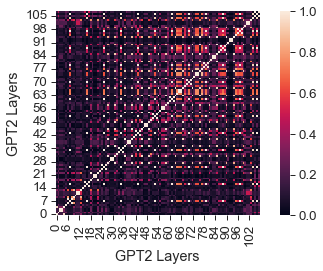

  0%|          | 0/108 [00:00<?, ?it/s]

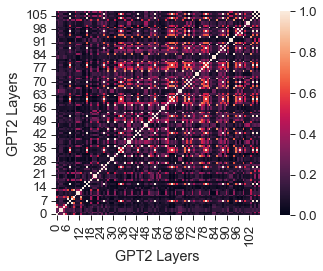

  0%|          | 0/108 [00:00<?, ?it/s]

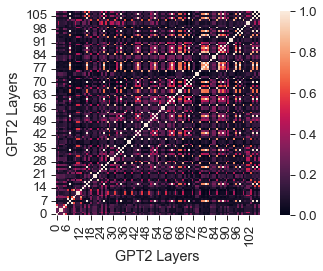

Starting new experiment: halfcheetah medium
1000 trajectories, 1000000 timesteps found
Average return: 4770.33, std: 355.75
Max return: 5309.38, min: -310.23
Loading from pretrained
Loaded from ../../checkpoints/gpt2_medium_halfcheetah_666/model_40.pt


/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loading from pretrained
Loaded from ../../checkpoints/gpt2_medium_halfcheetah_666/model_40.pt


  0%|          | 0/108 [00:00<?, ?it/s]

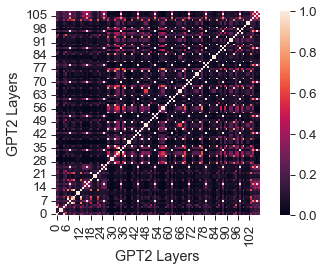

  0%|          | 0/108 [00:00<?, ?it/s]

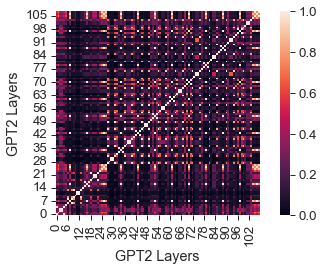

  0%|          | 0/108 [00:00<?, ?it/s]

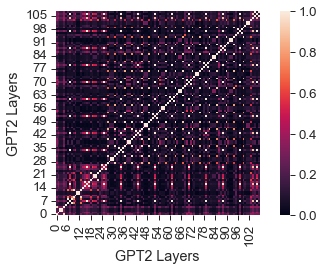

Starting new experiment: walker2d medium
1190 trajectories, 999995 timesteps found
Average return: 2852.09, std: 1095.44
Max return: 4226.94, min: -6.61
Loading from pretrained
Loaded from ../../checkpoints/gpt2_medium_walker2d_666/model_40.pt


/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loading from pretrained
Loaded from ../../checkpoints/gpt2_medium_walker2d_666/model_40.pt


  0%|          | 0/108 [00:00<?, ?it/s]

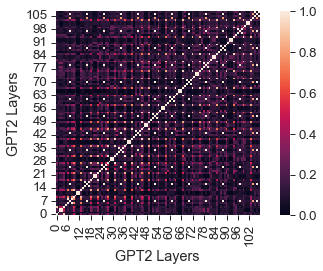

  0%|          | 0/108 [00:00<?, ?it/s]

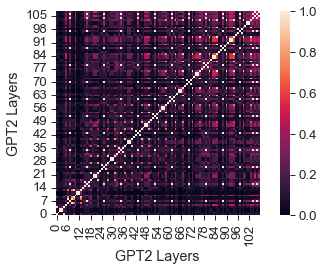

  0%|          | 0/108 [00:00<?, ?it/s]

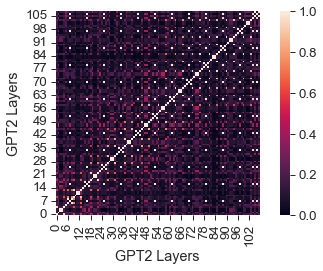

In [6]:
cka_matrix = run_cka(
    seed=666,
    model1='gpt2',
    model2='gpt2',
    epoch1=40,
    epoch2=40,
    env_name_list=['hopper', 'halfcheetah', 'walker2d'],
    block=False,
    no_context=False
    )